# COMP9444 Project Report: Building a Cart Pole game using Reinforcement Learning

## Reinforcement learning method 1: REINFORCE

***

<a id='sections'></a>

## [Sections](#sections)

#### [Summary](#summary)

#### [Importing Packages](#Importing-Packages)

#### [Hyperparameters](#Hyperparameters)

#### [Instantiating the agent](#Instantiating-the-Agent)

#### [Defining the policy](#Defining-the-policy)

#### [Instantiating the environment](#Instantiating-the-Environment)

#### [Running REINFORCE](#Running-REINFORCE)

<a id='summary'></a>

#### REINFORCE stands for "**RE**ward **I**ncrement = **N**on-negative **F**actor **O**ffset **R**einforcement **C**haracteristic **E**ligibility", which is a monte carlo variation of the  Policy Gradient Reinforcement Learning algorithm. This algorithm is implemented by creating a policy, which uses a state to determine the probability of selecting an action as an output. This policy is then continuously repeated whilst slightly modifying the policy until a policy that controls the system is obtained.

<a id='importing_packages'></a>

### Importing Packages

#### Import the necessary packages required.

In [1]:
from torch.distributions import Categorical
import torch
from collections import deque
import gym
import numpy as np
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<a id='hyperparameters'></a>

### Hyperparameters

#### The hyperparameters are declared here so that it is easier for us to change the parameters of the policy algorithm to see the effects of altering such hyperparameters on the effectiveness of this reinforcement learning method on learning the Cart Pole game, which is determined by the number of episodes for it to successfully train.

In [2]:
batch_size = 1000
lr = 0.001
gamma = 0.999
hid = 50
num_episodes = 2000
avg_steps = 195
continue_reward = 1
fail_reward = -400
epoch = 50
seed = 100
torch.manual_seed(seed)
random.seed(seed)

<a id='instantiating_the_agent'></a>

### Instantiating the Agent

#### The Cart Pole agent will calculate the probability of taking the next action (moving either left or right) according to its current state. This calculation is guided by the Policy that decides what action the agent should take. The probability of taking the next action is then returned and the agent will decide which action to take next.

In [3]:
class Agent():
    def __init__(self, action_dim, device) -> None:
        self.current_step = 0
        self.action_dim = action_dim
        self.device = device

    def get_action(self, state, policy_net): 
        self.current_step += 1
        pred = policy_net(torch.tensor(state).to(device).unsqueeze(0))
        distribution = Categorical(pred)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action)

<a id='defining_the_policy'></a>

### Defining the Policy

#### The policy we decided to use was a simple 3-layer fully connected network that takes in the states as an input and outputs probability distributions of each action needed to be taken by the agent. The agent will then take probability distributions and take the best action based on the policy itself. The aim of this policy is to maximize the expected reward. Since the output is a probability, we use a softmax activation function instead of ReLU because the softmax function has an output probability range of 0 to 1, where the sum of all probabilities is equal to one. The expected reward is the sum of products of discounted rewards and a log of probabilities, where rewards are discounted by a factor of Gamma.

In [4]:
class model(torch.nn.Module): 
    def __init__(self, state_dim, action_dim) -> None:
        super(model, self).__init__()
        self.in_to_hid1 = torch.nn.Linear(state_dim, hid)
        self.hid1_to_hid2 = torch.nn.Linear(hid, hid)
        self.hid2_to_out = torch.nn.Linear(hid, action_dim)

    def forward(self, input):
        hid1_sum = self.in_to_hid1(input)
        self.hid1 = torch.relu(hid1_sum)
        hid2_sum = self.hid1_to_hid2(self.hid1)
        self.hid2 = torch.relu(hid2_sum)
        output_sum = self.hid2_to_out(self.hid2)
        output = F.softmax(output_sum, dim=1)
        return output

<a id='instantiating_the_environment'></a>

### Instantiating the Environment

#### The Cart Pole game environment is relatively simple. It has a discrete action space of 2, as you can only either move left or right. The Cart Pole's state space, also known as observation space consists of only 4 dimensions, which is the angle of the pole, the horizontal position of the cart, angular velocity of the pole and the velocity of the cart. 

#### This is proven correct by the code below  that returns an output of two for the Cart Pole environment's action space and an output of 4 for the Cart Pole environment's obversation space (state space).

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make('CartPole-v1')
env.seed(0)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
agent = Agent(action_dim, device)
device
print('action space:', action_dim)
print('obversation space:', state_dim)

action space: 2
obversation space: 4


C:\Users\22339\AppData\Roaming\Python\Python39\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
C:\Users\22339\AppData\Roaming\Python\Python39\site-packages\gym\core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


<a id='running_REINFORCE'></a>

### Running REINFORCE

#### Firstly, we use the Policy we defined earlier to simulate and play the Cart Pole game. The action probability distributions are then recorded from the training. The target net is used for calculating Q next value to evaluate the Q value that we obtained from the policy net. The trajectory is then calculated by playing the game by sampling the action probabilities from the current policy. We then use this to calculate the total expected reward, which is stored in reward_batch and log_prob_batch. We then apply a discounted factor of gamma to recalculate the total expected reward and calculate the loss. For the discounted factor and loss function calculations, we use batches to increase the rate of training. However, since REINFORCE uses gradient ascent instead of descent, we use negative rewards to calculate the loss function. The discounted dewards are then calculated for each step through backpropagation using the optimizer defined above. The code below is purely for testing purposes.
#### To visualise how REINFORCE plays the Cart Pole game as the number of episodes increase, the env.render() line can be uncommented to give a visual representation of the Cart Pole game.

In [6]:
policy_net = model(state_dim, action_dim).to(device)
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr)

round_batch = []
total_round = []
avg_reward = []
avg_round = []
num_success = 0
# total reward is for testing purpose
for episode in range(1, num_episodes + 1):
    state = env.reset(seed=seed)
    round = 0
    success = False
    acc_reward = 0
    c_reward = continue_reward
    done = False
    reward_batch = deque(maxlen=batch_size)
    log_prob_batch = deque(maxlen=batch_size)

    # Try to play game, if done, the loop ends
    while not done:
        action, log_prob = agent.get_action(state, policy_net)
        state, reward, done, _ = env.step(action)
        if done:
            reward = fail_reward
        else:
            reward = c_reward
            c_reward += 0.1
        acc_reward += reward
        reward_batch.append(reward)
        log_prob_batch.append(log_prob)

        round += 1
        if done:
            round_batch.append(round)
            total_round.append(round)
            avg_reward.append(acc_reward)
            break

    # Training
    discount_batch = [gamma ** i for i in range(len(reward_batch))]
    expected_reward = 0
    for index in range(len(reward_batch)):
        expected_reward += discount_batch[index] * reward_batch[index]
        
    loss_batch = [-lp * expected_reward for lp in log_prob_batch]
    loss = torch.cat(loss_batch).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
            
    # For testing purpose
    if episode > 0 and episode % epoch == 0:
        print("episode {}, avg step: {:.2f}, avg reward: {:.2f}".format(episode, np.mean(round_batch), np.mean(avg_reward)))
        avg_round.append(np.mean(round_batch))
        round_batch = []
        avg_reward = []
env.close()

for rounds in avg_round:
    if rounds >= avg_steps:
        num_success += 1
print('Numbers of success: {} Successful rate: {:.2f} Average steps: {}'.format(num_success, (num_success / (num_episodes / epoch)), np.mean(avg_round)))

episode 50, avg round: 22.44, avg reward: -350.11
episode 100, avg round: 20.04, avg reward: -359.41
episode 150, avg round: 25.46, avg reward: -336.13
episode 200, avg round: 21.88, avg reward: -354.20
episode 250, avg round: 26.92, avg reward: -328.47
episode 300, avg round: 35.36, avg reward: -289.79
episode 350, avg round: 43.42, avg reward: -252.18
episode 400, avg round: 52.28, avg reward: -194.41
episode 450, avg round: 57.88, avg reward: -137.96
episode 500, avg round: 101.50, avg reward: 288.84
episode 550, avg round: 89.46, avg reward: 177.75
episode 600, avg round: 161.96, avg reward: 1176.27
episode 650, avg round: 150.64, avg reward: 929.77
episode 700, avg round: 121.32, avg reward: 471.65
episode 750, avg round: 188.00, avg reward: 1658.69
episode 800, avg round: 220.00, avg reward: 2552.77
episode 850, avg round: 217.92, avg reward: 2385.25
episode 900, avg round: 242.66, avg reward: 2979.55
episode 950, avg round: 280.72, avg reward: 4637.30
episode 1000, avg round: 17

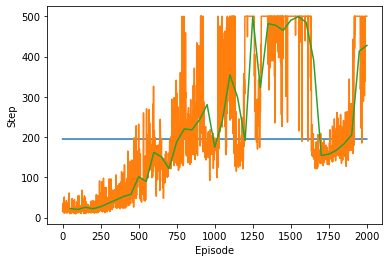

In [7]:
plt.plot(range(num_episodes), [avg_steps] * num_episodes)
plt.plot(range(num_episodes), total_round)
plt.plot(np.linspace(epoch, num_episodes, num= int(num_episodes / epoch)), avg_round)
plt.xlabel('Episode')
plt.ylabel('Step')
plt.show()